In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from ipywidgets import *
import datetime as dt
import skfda
from skfda.misc.hat_matrix import (
    KNeighborsHatMatrix,
    LocalLinearRegressionHatMatrix,
    NadarayaWatsonHatMatrix,
)
from skfda.misc.kernels import uniform
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
from scipy.ndimage import gaussian_filter1d
from skfda import FDataGrid

import py7zr
from subprocess import check_output
import os

from data_mgmt import *

# Some useful functions

In [2]:
# function that takes a tensor and saves it to a file
def save_tensor(tensor, filename):
    torch.save(tensor, filename)
    print(f'Saved tensor of shape {tensor.shape} to {filename}')

# function that groups the data by item and store, and is ordered by date
def group_data(data, group_by, target):
    # grouped = data.groupby(group_by)[target].apply(lambda x: list(range(30)))
    grouped = data.groupby(group_by)[target].apply(lambda x: x.tolist())
    # grouped = data.groupby(group_by)[target].apply(lambda x: len(x))
    grouped = grouped.reset_index()
    return grouped

# function that takes a dataframe and returns a tensor of shape (num_items, num_stores, num_days)
# where each row is a time series of unit_sales
def get_tensor_from_df(df, idx_for_group, drop_columns=None, transpose=False):
    if drop_columns:
        df = df.drop(columns=drop_columns, axis=1)
    gb = df.groupby(by=idx_for_group)
    # for key, item in gb:
    #     print(gb.get_group(key), "\n\n")
    tensor =  torch.stack([torch.tensor(group.drop(columns=idx_for_group).values) for name, group in gb], dim=1)
    if transpose:
        tensor = tensor.transpose(0, 1)

    return tensor

# function that takes a dataframe and returns 2 tensors of shape (num_items, num_stores, num_days)
# where each row is a time series of unit_sales
# one tensor corresponds to weekly sales, and the second to daily sales
def get_weekly_and_daily_sales_tensors(df, idx_for_group, drop_columns, transpose=False):

    daily_sales = get_tensor_from_df(df, idx_for_group, drop_columns, transpose=transpose)
    weekly_sales = torch.stack([daily_sales[:, :, 7*i: 7*(i+1)].sum(dim=2) for i in range(int(daily_sales.shape[2]/7))], dim=2)

    return weekly_sales, daily_sales

# function that gets grouped_df and returns a pytorch tensor, where each row is a time series of unit_sales
def stack_to_tensor(grouped_df):
    tensor_list = []
    for i in range(len(grouped_df)):
        tensor_list.append(torch.tensor(grouped_df.iloc[i, 2]))
    return torch.stack(tensor_list)

# Plot functions

In [4]:
def plot_many_axis(sales, item, store, fig_size=None, set_legend=True, xlabel=None, ylabel=None, prices=None, time_scale='Weeks', smooth=True, christmas_weeks=None, earthquake_weeks=[171], start_week=0, end_week=-1, year_ticks=False, save_name=None, to_save=False):

    plt.clf()
    # change font size
    plt.rcParams.update({'font.size': 14})
    sales = sales[:, :, start_week:end_week]

    # if item is a list
    if type(item) is list:
        # create n subplots vertically, and plot each item in a subplot
        n = len(item) + 1
        # plt.figure(figsize=(10,6))
        fig, axs = plt.subplots(n, 1, sharex=True, gridspec_kw={'height_ratios': [1 for _ in range(n-1)] + [3]})
        plt.subplots_adjust(hspace=0.18)
        for i, ax in enumerate(axs):
            if i == n-1:
                this_sales = sales.sum(dim=[0, 1])/(10**6)
                ax.plot(this_sales, label='Cummulative sales')
            else:
                this_sales = sales[item[i], store]
                ax.plot(this_sales, label='Weekly sales')
                ax.set_ylim(bottom=0)
            if smooth: # smooth the data with gaussian filter
                smoothed = gaussian_filter1d(this_sales, sigma=6)
                ax.plot(smoothed, label='Gaussian smoothing', linestyle='dashed')

            if i == int(n/2) - 1:
                ax.set_ylabel('Units \n')
            if i == n-1:
                ax.set_ylabel('Million units')
                ax.set_xlabel('Date')
                # ax.legend(loc='upper left')
            # start y axis at 0
            # plt.tick_params(
            #     axis='x',          # changes apply to the x-axis
            #     which='both',      # both major and minor ticks are affected
            #     bottom=False,      # ticks along the bottom edge are off
            #     top=False,         # ticks along the top edge are off
            #     labelbottom=False)

            if year_ticks:
                ax.set_xticks(np.arange(0, end_week, 52))
                ax.set_xticklabels((np.arange(start_week, end_week, 52)/52 + 2013).astype(int))
    else:
        # plt.figure(figsize=(10,6))
        fig, ax1 = plt.subplots()
        if item==-1:  # sum over all items if item=-1
            this_sales = sales.sum(dim=[0, 1])
        else:
            this_sales = sales[item, store]

        ax1.plot(this_sales, label='Weekly sales')

        if smooth: # smooth the data with gaussian filter
            smoothed = gaussian_filter1d(this_sales, sigma=6)
            # create dashed line for smoothed data
            ax1.plot(smoothed, label='Gaussian smoothing', linestyle='dashed')

            
        ax1.set_xlabel(xlabel) if xlabel else ax1.set_xlabel(time_scale)
        ax1.set_ylabel(ylabel) if ylabel else ax1.set_ylabel('Units')

        if set_legend:
            ax1.legend()
        # ax1.legend(loc='upper left')

        if year_ticks:
            ax1.set_xticks(np.arange(0, end_week, 52))
            ax1.set_xticklabels((np.arange(start_week, end_week, 52)/52 + 2013).astype(int))
        
            
    # plot christmas weeks
    line_colors = ['red', 'green']
    labels = ['Christmas', 'Earthquake']
    # for i, special_weeks in enumerate([christmas_weeks, earthquake_weeks]):
    for i, special_weeks in enumerate([christmas_weeks]):
        if special_weeks is not None:
            for week in special_weeks:
                if week < end_week:
                    ax1.axvline(x=week, color=line_colors[i], linestyle='--', label=labels[i])



    if not prices is None:
        ax2 = ax1.twinx()
        ax2.set_ylabel('USD')
        ax2.legend(loc='upper right')
        ax2.plot(prices[item, store], label='prices')        
    
    if fig_size:
        fig.set_size_inches(*fig_size)
        if item == -1:
            plt.tight_layout()
    
    if to_save:
        date = get_year_month_day()
        create_folder_if_not_exists(f'Figures/{date}')
        plt.savefig(f'Figures/{date}/{save_name}.png')
        plt.savefig(f'Figures/{date}/{save_name}.pdf')
    plt.show()

In [5]:
def calculate_sold_on_or_before(weekly_sales, weekly_prices=None):

    n_products, n_stores, n_weeks = weekly_sales.shape

    if weekly_prices is None:
        sold_on_week = (weekly_sales > 0.1).long()
    else:
        sold_on_week = ((weekly_prices[:, :, :n_weeks] > 0.01) & (weekly_sales[:, :, :n_weeks] > 0.1)).long()
        
    return (sold_on_week.cumsum(dim=2) > 0.5).long()

# number of distinct products that already started to be sold by a specific week
def plot_sold_on_or_before(weekly_sales, weekly_prices=None):
    n_products, n_stores, n_weeks = weekly_sales.shape
        
    sold_on_or_before = calculate_sold_on_or_before(weekly_sales, weekly_prices)
    products_store_sold_by_period = sold_on_or_before.sum(dim=[0, 1])/(n_products*n_stores)

    plt.clf()
    plt.plot(products_store_sold_by_period)
    plt.xlabel('Weeks')
    plt.ylabel('Percentage of store-products on sale')
    plt.show()


# percentage of weeks in which there were zero sales
def calculate_percentage_of_zero_weekly_sales(weekly_sales, first_week=0, adjusted=False):

    weekly_sales = weekly_sales[:, :, first_week:]
    n_weeks = weekly_sales.shape[2]
    zero_weekly_sales = (weekly_sales == 0).long().sum(dim=2)
    if not adjusted:
        percentage_zero_weekly_sales = zero_weekly_sales/(n_weeks)

    else: # if adjusted, subtract the number of weeks in which the product was not sold before normalizing
        sold_on_or_before = calculate_sold_on_or_before(weekly_sales)
        number_of_days_from_first_sale = sold_on_or_before.sum(dim=2)
        percentage_zero_weekly_sales = (zero_weekly_sales - (n_weeks - number_of_days_from_first_sale))/number_of_days_from_first_sale
        percentage_zero_weekly_sales = percentage_zero_weekly_sales.clamp(min=0, max=1)
        # percentage_zero_weekly_sales = percentage_zero_weekly_sales[torch.isfinite(percentage_zero_weekly_sales)]
    
    return percentage_zero_weekly_sales

# plot percentage of weeks in which there were zero sales
def plot_percentage_of_zero_weekly_sales(weekly_sales, first_week=0, adjusted=False, title=None):

    percentage_zero_weekly_sales = calculate_percentage_of_zero_weekly_sales(weekly_sales, first_week, adjusted)

    plt.clf()
    plt.hist(percentage_zero_weekly_sales.flatten().tolist(), bins=20)
    plt.xlabel('Percentage of zero weekly sales\n(adjusted for weeks before product first sale)')
    plt.ylabel('Number of products-stores')
    if title:
        plt.title(title)
    # plt.scatter(range(n_products*n_stores), zero_weekly_sales.flatten(), s=1)
    plt.show()

# function that receives a weekly sales tensor, and only keeps rows that have a percentage of zero sales below a threshold and were sold by a specific week
def filter_weekly_sales(weekly_sales, daily_sales, weekly_non_zero_percentage, sold_on_or_before, zero_sales_percentage_thresh, sold_by_week):

    # filter out rows that have a percentage of zero sales above a threshold
    filters = (weekly_non_zero_percentage < zero_sales_percentage_thresh) & (sold_on_or_before[:, :, sold_by_week] == 1)
    weekly_sales_filtered = weekly_sales[filters]
    daily_sales_filtered = daily_sales[filters]
    return weekly_sales_filtered.unsqueeze(1), daily_sales_filtered.unsqueeze(1)

def get_boolean_filters_for_tensors(weekly_sales, zero_sales_percentage_thresh, sold_by_week,  first_week=0, adjusted=True):
    
    weekly_sold_on_or_before = calculate_sold_on_or_before(weekly_sales)

    if adjusted:
        weekly_non_zero_percentage = calculate_percentage_of_zero_weekly_sales(weekly_sales, first_week=first_week, adjusted=True)
    else:
        weekly_non_zero_percentage = calculate_percentage_of_zero_weekly_sales(weekly_sales, first_week=first_week, adjusted=False)

    boolean_filters = (weekly_non_zero_percentage < zero_sales_percentage_thresh) & (weekly_sold_on_or_before[:, :, sold_by_week] == 1)
    return boolean_filters[:, 0]

In [6]:
# in a dataframe, replace values of unit_sales that are not int with 0
def replace_non_int(df):
    df['unit_sales'] = df['unit_sales'].apply(lambda x: 0 if isinstance(x, str) else x)
    return df

def create_pivoted_df(df, file_name):

    # in a dataframe, replace values of unit_sales that are not int with 0
    df = replace_non_int(df)

    # drop rows where data does not meet formatting requirements
    df['date'] = (pd.to_datetime(df['date'], errors='coerce'))

    # change nan onpromotion values to 0
    df['onpromotion'] = df['onpromotion'].fillna(0)

    # change onpromotion from bool to int
    df['onpromotion'] = df['onpromotion'].astype(int)

    # drop rows where date is not datetime
    df = df.dropna(subset=['date'])

    # pivot table so that each row corresponds to the time series of a single item in a single store
    df_pivoted = df.pivot_table(index=['store_nbr', 'item_nbr'], columns='date', values='unit_sales').reset_index().fillna(0)
    df_pivoted.to_csv(f'Input/working/{file_name}.csv', index=False)

    df_pivoted_onprom = df.pivot_table(index=['store_nbr', 'item_nbr'], columns='date', values='onpromotion').reset_index().fillna(0)
    df_pivoted_onprom.to_csv(f'Input/working/{file_name}_onprom.csv', index=False)

In [7]:
# function that reads data from a pivoted df, applies filters (e.g. non-perishable, zero sales percentage, etc.) and saves a series of 
# tensors (weekly/daily sales/onprom) and one dataframe with the info (item_nbr, store_nbr, family) of each row of the tensor
# flattened_no_perishable_week_50_thresh_0.1_adjusted
def create_filtered_tensors_from_pivoted_df(directory, filename, delete_perishables, zero_sales_percentage_thresh, sold_by_week, first_week=0, adjusted=True):

    # load train_pivoted dataframe from file
    train_pivoted = pd.read_csv(f'Input/working/{filename}.csv')
    train_pivoted_onprom = pd.read_csv(f'Input/working/{filename}_onprom.csv')

    print(1)

    # load items dataframe from file
    items = pd.read_csv('Input/working/items.csv')

    if delete_perishables:
        # filter by non-perishable items
        non_perishable = items[items['perishable'] == 0].item_nbr

        # filter train_pivoted to only keep non-perishable items
        filtered_pivoted = train_pivoted[train_pivoted['item_nbr'].isin(non_perishable)]
        filetered_onprom = train_pivoted_onprom[train_pivoted_onprom['item_nbr'].isin(non_perishable)]
    else:
        filtered_pivoted = train_pivoted
        filetered_onprom = train_pivoted_onprom

    print(2)

    # add a column that is the concatenation of store_nbr and item_nbr
    filtered_pivoted['store_item'] = filtered_pivoted['store_nbr'].astype(str) + '_' + filtered_pivoted['item_nbr'].astype(str)
    # remove duplicate entries of store_item
    filtered_pivoted = filtered_pivoted.drop_duplicates(subset=['store_item'])
    weekly_sales_flattened, daily_sales_flattened = get_weekly_and_daily_sales_tensors(filtered_pivoted, 'store_item', drop_columns=['item_nbr', 'store_nbr'], transpose=True)

    print(3)

    # add a column that is the concatenation of store_nbr and item_nbr
    filetered_onprom['store_item'] = filetered_onprom['store_nbr'].astype(str) + '_' + filetered_onprom['item_nbr'].astype(str)
    # remove duplicate entries of store_item
    filetered_onprom = filetered_onprom.drop_duplicates(subset=['store_item'])
    weekly_onprom_flattened, daily_onprom_flattened = get_weekly_and_daily_sales_tensors(filetered_onprom, 'store_item', drop_columns=['item_nbr', 'store_nbr'], transpose=True)

    # get boolean filters, from percentage of zero sales and sold by week parameters
    boolean_filters = get_boolean_filters_for_tensors(weekly_sales_flattened, 
                                                    zero_sales_percentage_thresh=zero_sales_percentage_thresh, 
                                                    sold_by_week=sold_by_week, 
                                                    first_week=first_week, 
                                                    adjusted=adjusted)

    print(boolean_filters.shape)
    folder = f'Input/favorita-tensors/{directory}'
    create_folder_if_not_exists(folder)

    strings = ['weekly_sales', 'daily_sales', 'weekly_onprom', 'daily_onprom']
    tensors = [weekly_sales_flattened, daily_sales_flattened, weekly_onprom_flattened, daily_onprom_flattened]
    # iterate over strings and tensors, to save tensor on file
    for string, tensor in zip(strings, tensors):
        print(tensor.shape)
        print(tensor[boolean_filters].shape)
        save_tensor(tensor[boolean_filters], f'{folder}/{string}.pt')

    # in filtered_pivoted, keep rows according to boolean_filters, and only keep store_nbr and item_nbr columns
    remaining_filtered_pivoted = filtered_pivoted[boolean_filters.tolist()][['store_nbr', 'item_nbr']].join(items.set_index('item_nbr'), on='item_nbr')
    remaining_filtered_pivoted.to_csv(f'{folder}/tensors_row_info.csv', index=False)

In [8]:
def load_tensors_and_row_info_df(directory):
    folder = f'Input/favorita-tensors/{directory}'
    weekly_sales = torch.load(f'{folder}/weekly_sales.pt')
    daily_sales = torch.load(f'{folder}/daily_sales.pt')
    weekly_onprom = torch.load(f'{folder}/weekly_onprom.pt')
    daily_onprom = torch.load(f'{folder}/daily_onprom.pt')
    row_info_df = pd.read_csv(f'{folder}/tensors_row_info.csv')
    return weekly_sales, daily_sales, weekly_onprom, daily_onprom, row_info_df

In [9]:
# function that reads data from a pivoted df, applies filters (e.g. non-perishable, zero sales percentage, etc.) and saves a series of 
# tensors (weekly/daily sales/onprom) and one dataframe with the info (item_nbr, store_nbr, family) of each row of the tensor
# flattened_no_perishable_week_50_thresh_0.1_adjusted
def create_filtered_tensors_from_tensors_and_row_info(input_directory, output_directory, delete_perishables, zero_sales_percentage_thresh, sold_by_week, 
                                                      first_week=0, adjusted=True, save=False, loaded_data=None):

    if loaded_data is not None:
        weekly_sales, daily_sales, weekly_onprom, daily_onprom, tensors_row_info = loaded_data
    else:
        # # load week_sales_flattened, daily_sales_flattened, weekly_onprom_flattened, daily_onprom_flattened tensors and tensors_row_info df from file
        # # load tensors_row_info from file
        weekly_sales, daily_sales, weekly_onprom, daily_onprom, tensors_row_info = load_tensors_and_row_info_df(input_directory)
        # weekly_sales = torch.load(f'Input/favorita-tensors/{input_directory}/weekly_sales.pt')
        # daily_sales = torch.load(f'Input/favorita-tensors/{input_directory}/daily_sales.pt')
        # weekly_onprom = torch.load(f'Input/favorita-tensors/{input_directory}/weekly_onprom.pt')
        # daily_onprom = torch.load(f'Input/favorita-tensors/{input_directory}/daily_onprom.pt')

        # tensors_row_info = pd.read_csv(f'Input/favorita-tensors/{input_directory}/tensors_row_info.csv')


    # get boolean filters, from percentage of zero sales and sold by week parameters
    boolean_filters = get_boolean_filters_for_tensors(weekly_sales, 
                                                    zero_sales_percentage_thresh=zero_sales_percentage_thresh, 
                                                    sold_by_week=sold_by_week, 
                                                    first_week=first_week, 
                                                    adjusted=adjusted)

    # print(torch.tensor((tensors_row_info['perishable'] == 0)).shape)
    # print(boolean_filters.shape)
    if delete_perishables:
        boolean_filters = (boolean_filters & torch.tensor((tensors_row_info['perishable'] == 0)))
    # folder = f'Input/favorita-tensors/{directory}'

    # print(boolean_filters)
    # print(tensors_row_info)
    strings = ['weekly_sales', 'daily_sales', 'weekly_onprom', 'daily_onprom']
    tensors = [weekly_sales, daily_sales, weekly_onprom, daily_onprom]
    
    # print the shape of weekly_sales

    if save:
        create_folder_if_not_exists(f'Input/favorita-tensors/{output_directory}')
        # iterate over strings and tensors, to save tensor on file
        for string, tensor in zip(strings, tensors):
            save_tensor(tensor[boolean_filters], f'Input/favorita-tensors/{output_directory}/{string}.pt')

        # in filtered_pivoted, keep rows according to boolean_filters, and only keep store_nbr and item_nbr columns
        tensors_row_info[boolean_filters.tolist()].to_csv(f'Input/favorita-tensors/{output_directory}/tensors_row_info.csv', index=False)
    else:
        print(f'weekly_sales.shape: {weekly_sales[boolean_filters].shape}')


In [10]:
input_directory = 'flattened_all'
loaded_data = load_tensors_and_row_info_df(input_directory)

FileNotFoundError: [Errno 2] No such file or directory: 'Input/favorita-tensors/flattened_all/weekly_sales.pt'

In [ ]:
# from tensors and row information dataframe, create a filtered dataframe according to sales threshold, sold by week, and perishable
input_directory = 'flattened_all'
delete_perishables = True
zero_sales_percentage_thresh = 0.1
sold_by_week = 16
output_directory = f'flattened_no_perishable_week_{sold_by_week}_thresh_{zero_sales_percentage_thresh}_adjusted'
save=True
create_filtered_tensors_from_tensors_and_row_info(input_directory, output_directory, delete_perishables, 
                                                  zero_sales_percentage_thresh, sold_by_week, save=save, loaded_data=loaded_data)

Saved tensor of shape torch.Size([33945, 1, 240]) to Input/favorita-tensors/flattened_no_perishable_week_16_thresh_0.1_adjusted/weekly_sales.pt
Saved tensor of shape torch.Size([33945, 1, 1684]) to Input/favorita-tensors/flattened_no_perishable_week_16_thresh_0.1_adjusted/daily_sales.pt
Saved tensor of shape torch.Size([33945, 1, 240]) to Input/favorita-tensors/flattened_no_perishable_week_16_thresh_0.1_adjusted/weekly_onprom.pt
Saved tensor of shape torch.Size([33945, 1, 1684]) to Input/favorita-tensors/flattened_no_perishable_week_16_thresh_0.1_adjusted/daily_onprom.pt


# Favorita Dataset

## Exctraction of data from the 7z file (don't run again)

In [ ]:
# Extracting the data from the 7z file to a .csv file (not necessary to run again)
exit()
for dirname, _, filenames in os.walk('Input/favorita-grocery-sales-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        archive = py7zr.SevenZipFile(os.path.join(dirname, filename), mode='r')
        archive.extractall(path="Input/working")
        archive.close()

# print(check_output(["ls", "../working"]).decode("utf8"))

Input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
Input/favorita-grocery-sales-forecasting/transactions.csv.7z
Input/favorita-grocery-sales-forecasting/items.csv.7z
Input/favorita-grocery-sales-forecasting/test.csv.7z
Input/favorita-grocery-sales-forecasting/train.csv.7z
Input/favorita-grocery-sales-forecasting/stores.csv.7z
Input/favorita-grocery-sales-forecasting/oil.csv.7z
Input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


## Reading and preprocessing the data, until dump as a tensor

### Read data, pivot (i.e., to make each row a time series of a single item in a single store), and save to file
### Don't execute again, since the file is already saved

In [ ]:
exit()

# Reading the data from the .csv files
items = pd.read_csv("Input/working/items.csv")
holidays = pd.read_csv("Input/working/holidays_events.csv")
test = pd.read_csv("Input/working/test.csv", nrows=600000  , parse_dates=['date'])
train_small = pd.read_csv("Input/working/train.csv", nrows=600000  , parse_dates=['date'])
train = pd.read_csv("Input/working/train.csv", names = train_small.columns, parse_dates = ['date'])

## train = pd.read_csv("Input/working/train.csv", skiprows = 115000000, names = train_small.columns, parse_dates = ['date'])



In [12]:
exit()
train_small = pd.read_csv("Input/working/train.csv", nrows=600000  , parse_dates=['date'])
create_pivoted_df(train_small, 'train_pivoted')

In [ ]:
create_pivoted_df(train, 'train_pivoted')
create_pivoted_df(train_small, 'train_small_pivoted')

In [ ]:
# tried dusing Dask but still fails due to out of memory
# import dask.dataframe as dd
# from dask.diagnostics import ProgressBar
# import gc
# import pandas as pd  # Only for non-Dask compatible operations

# def replace_non_int(df):
#     # Dask apply does not work exactly like pandas, often requiring meta information
#     df['unit_sales'] = df['unit_sales'].apply(lambda x: 0 if isinstance(x, str) else x, meta=('unit_sales', 'int'))
#     return df

# def create_pivoted_df(df, file_name):
#     df = replace_non_int(df)
#     df['date'] = dd.to_datetime(df['date'], errors='coerce')
#     df['onpromotion'] = df['onpromotion'].fillna(0).astype(int)
#     df = df.dropna(subset=['date'])

#     # Because Dask does not directly support pivot_table as pandas does, we need to compute first
#     df = df.compute()

#     # Now we can use pandas to pivot the data (since it's smaller and manageable)
#     df_pivoted = df.pivot_table(index=['store_nbr', 'item_nbr'], columns='date', values='unit_sales').reset_index().fillna(0)
#     df_pivoted.to_csv(f'Input/working/{file_name}.csv', index=False)
#     del df_pivoted
#     gc.collect()
    
#     df_pivoted_onprom = df.pivot_table(index=['store_nbr', 'item_nbr'], columns='date', values='onpromotion').reset_index().fillna(0)
#     df_pivoted_onprom.to_csv(f'Input/working/{file_name}_onprom.csv', index=False)

# # Reading large datasets with Dask
# train_small = dd.read_csv("Input/working/train.csv", parse_dates=['date'])
# with ProgressBar():
#     create_pivoted_df(train_small, 'train_pivoted')

ValueError: An error occurred while calling the read_csv method registered to the pandas backend.
Original Message: The 'nrows' keyword is not supported by `dd.read_csv`. To achieve the same behavior, it's recommended to use `dd.read_csv(...).head(n=nrows)`

### Creating tensors and row_info df from the pivoted dataframes (in this case, for all items)

In [ ]:
directory = 'all'
delete_perishables = False
zero_sales_percentage_thresh = 1.0
sold_by_week = 239
create_filtered_tensors_from_pivoted_df(directory, 'train_pivoted', delete_perishables, zero_sales_percentage_thresh, sold_by_week)

1
2
3


IndexError: index 239 is out of bounds for dimension 2 with size 2

### Create date dataframe, including distance to christmas and earthquakes

In [ ]:
dates = pd.DataFrame.from_dict({'date': pd.date_range(start='2013-01-01', end='2017-08-15')})
# print(dates)
dates['day_of_week'] = (dates.date.dt.isocalendar().day).astype("int8")
dates['month'] = dates.date.dt.month.astype("int8")
dates['year'] = dates.date.dt.year
dates['day_of_month'] = dates.date.dt.day.astype("int8")

# filter for day_of_week = 2
dates = dates[dates['day_of_week'] == 2].reset_index(drop=True)

# create a list of all christmas days between 2013 and 2017 (inclusive)
christmas_dates = []
for year in range(2012, 2018):
    christmas_dates.append(dt.date(year, 12, 25))
# print(christmas_dates)

# add a column with a tuple to the distance in days to each christmas, but changing Timestamp to datetime.date
dates['days_from_christmas'] = dates['date'].apply(lambda x: min([(x.date() - christmas_date).days for christmas_date in christmas_dates] + 
                                                 [(christmas_date - x.date()).days for christmas_date in christmas_dates], key=abs))

# add a column stating if month is december and day is between 19 and 25)
dates['christmas'] = ((dates['month'] == 12) & (dates['day_of_month'] >= 19) & (dates['day_of_month'] <= 25)).astype("int8")
dates['earthquake'] = ((dates['year'] == 2016) &(dates['month'] == 4) & (dates['day_of_month'] >= 10) & (dates['day_of_month'] <= 16)).astype("int8")

christmas_weeks = dates[dates['christmas'] == 1].index.tolist()
earthquake_weeks = dates[dates['earthquake'] == 1].index.tolist()
print(christmas_weeks)
print(earthquake_weeks)
print(dates.head())
print(dates.tail())
print(dates.loc[170])

# # save dates dataframe to file
# dates.to_csv('Input/favorita-tensors/common_data/dates_with_info.csv', index=False)


[51, 103, 155, 207]
[171]
        date  day_of_week  month  year  day_of_month  days_from_christmas  \
0 2013-01-01            2      1  2013             1                    7   
1 2013-01-08            2      1  2013             8                   14   
2 2013-01-15            2      1  2013            15                   21   
3 2013-01-22            2      1  2013            22                   28   
4 2013-01-29            2      1  2013            29                   35   

   christmas  earthquake  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0  
          date  day_of_week  month  year  day_of_month  days_from_christmas  \
237 2017-07-18            2      7  2017            18                 -160   
238 2017-07-25            2      7  2017            25                 -153   
239 2017-08-01            2      8  2017             1                 -146   
240 2017-08-08            2      

### Create a tensor of dimensions (items, stores, periods) - not currently working

In [ ]:
# for every item, count the number of stores it is sold in
item_store_count = train_pivoted.groupby('item_nbr')['store_nbr'].nunique().reset_index()
print(item_store_count.describe())

NameError: name 'train_pivoted' is not defined

In [ ]:
# filter all items that are not sold in at least sold_in_n_stores stores

sold_in_n_stores = 54
items_sold_in_many_stores = item_store_count[item_store_count['store_nbr'] >= sold_in_n_stores].item_nbr.to_list()

# filter out items that are not sold in at least sold_in_n_stores stores
train_pivoted_filtered = train_pivoted[train_pivoted['item_nbr'].isin(items_sold_in_many_stores)]

# keep at most sold_in_n_stores rows for each item
train_pivoted_filtered = train_pivoted_filtered.groupby('item_nbr').head(sold_in_n_stores).reset_index(drop=True)
# print(train_pivoted_filtered.head())

[103520, 105693, 105857, 106716, 108079, 108701, 108786, 108797, 108952, 111223, 111397, 114790, 114799, 115267, 115693, 115720, 115850, 115892, 115893, 115894, 116017, 116279, 119023, 119141, 119624, 121964, 122419, 122425, 123601, 125430, 127534, 129296, 129297, 129635, 153239, 153267, 153395, 155607, 155610, 155621, 157956, 158788, 158875, 158956, 159242, 162066, 164647, 165550, 165594, 165693, 165704, 165718, 165727, 165988, 168989, 171890, 172184, 172343, 173111, 177050, 177395, 205387, 207857, 208384, 208498, 208514, 208530, 209085, 210798, 211203, 211205, 211206, 211999, 212550, 212552, 213066, 213652, 213653, 213788, 214381, 214859, 214860, 214862, 215303, 215304, 215327, 215331, 215332, 215352, 215356, 215370, 215468, 215896, 217827, 219150, 219152, 220435, 221506, 222879, 222975, 223068, 223136, 223434, 224081, 226126, 226857, 229368, 250782, 253103, 253145, 255161, 257847, 257848, 258376, 258395, 258396, 258411, 260669, 261052, 261053, 261700, 262991, 264299, 264751, 264752,

# Load and analyze data from favorita dataset

In [ ]:
# input_directory = 'flattened_all'
input_directory = 'flattened_no_perishable_week_16_thresh_0.1_adjusted'

# load week_sales_flattened, daily_sales_flattened, weekly_onprom_flattened, daily_onprom_flattened tensors and tensors_row_info df from file
# using only one function
weekly_sales, daily_sales, weekly_onprom, daily_onprom, tensors_row_info = load_tensors_and_row_info_df(input_directory)

# load items
items = pd.read_csv('Input/working/items.csv')

## Main plot of time series!

[15275, 33179, 19140, 28481]


<Figure size 640x480 with 0 Axes>

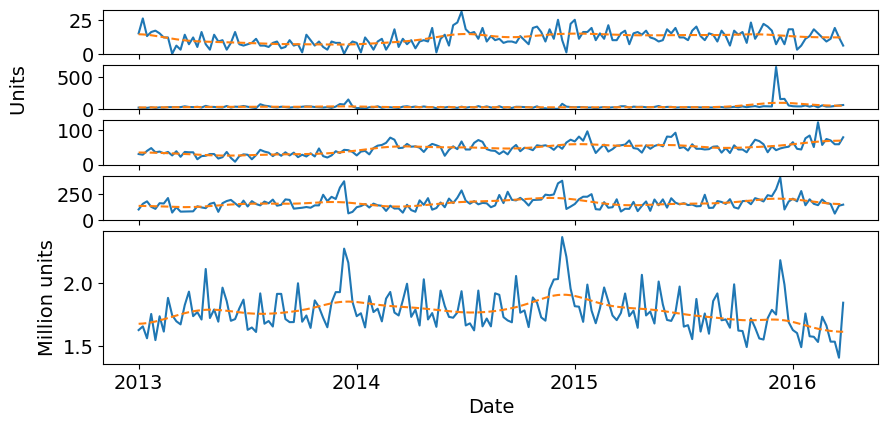

In [ ]:
store=0
item = [15275, 33179, 19140, 28481]
# item = [15275, 12084, 33179, 19140, 28481]
# item = np.random.randint(0, len(weekly_sales), size=5).tolist()
print(item)
save_name = 'sample_weekly_sales'
to_save=True
fig_size = (10, 4.6)
plot_many_axis(weekly_sales, item,  store, fig_size=fig_size, set_legend=False, smooth=True, xlabel="Date", ylabel="Units", christmas_weeks=None, 
               start_week=1, end_week=170, year_ticks=True, save_name=save_name, to_save=to_save)

In [ ]:
print(tensors_row_info.head())
# print the number of distinct store_nbr
print(tensors_row_info['store_nbr'].nunique())
print(tensors_row_info['item_nbr'].nunique())
print(tensors_row_info.shape)

   store_nbr  item_nbr        family  class  perishable
0          1     96995     GROCERY I   1093           0
1          1     99197     GROCERY I   1067           0
2          1    103520     GROCERY I   1028           0
3          1    103665  BREAD/BAKERY   2712           1
4          1    105574     GROCERY I   1045           0
54
4036
(174483, 5)


In [ ]:
print(weekly_sales.shape)

torch.Size([33945, 1, 240])


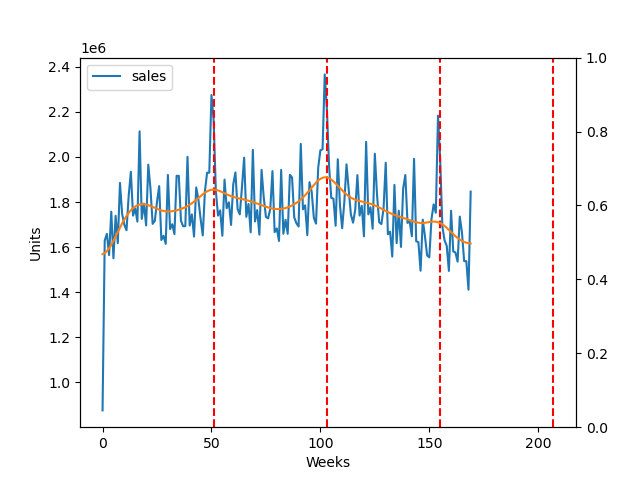

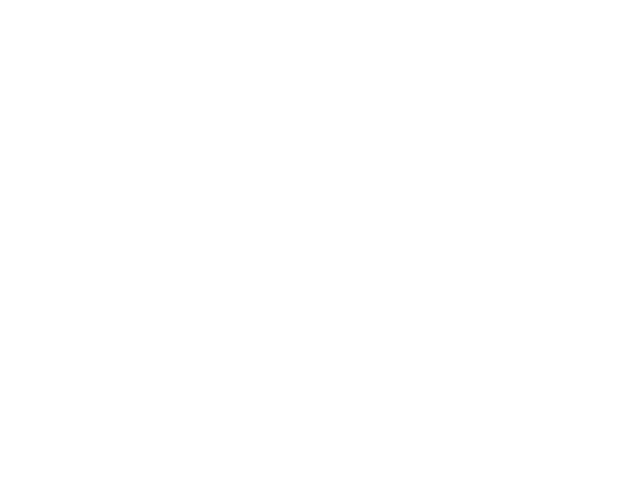

In [ ]:
%matplotlib ipympl
# plot the weekly sales of an item in a store
item = -1
# item = 12333
store = 0
# plot_many_axis(favorita_daily_sales_filtered, item, store)
plot_many_axis(weekly_sales, item, store, christmas_weeks=christmas_weeks, end_week=170)

In [ ]:
sales_by_family = {}

# iterate over unique families and append weekly_sales of each family to sales_by_family
for family in tensors_row_info['family'].unique():
    sales_by_family[family] = weekly_sales[tensors_row_info['family'] == family]
    print(family, sales_by_family[family].shape)

GROCERY I torch.Size([56110, 1, 240])
BREAD/BAKERY torch.Size([5036, 1, 240])
DELI torch.Size([4144, 1, 240])
CLEANING torch.Size([19413, 1, 240])
POULTRY torch.Size([2228, 1, 240])
PERSONAL CARE torch.Size([6913, 1, 240])
LINGERIE torch.Size([989, 1, 240])
BEVERAGES torch.Size([28515, 1, 240])
AUTOMOTIVE torch.Size([957, 1, 240])
DAIRY torch.Size([10756, 1, 240])
EGGS torch.Size([1438, 1, 240])
GROCERY II torch.Size([466, 1, 240])
MEATS torch.Size([2385, 1, 240])
FROZEN FOODS torch.Size([2251, 1, 240])
HOME APPLIANCES torch.Size([54, 1, 240])
SEAFOOD torch.Size([266, 1, 240])
PREPARED FOODS torch.Size([1227, 1, 240])
LIQUOR,WINE,BEER torch.Size([2299, 1, 240])
BEAUTY torch.Size([788, 1, 240])
HARDWARE torch.Size([212, 1, 240])
LAWN AND GARDEN torch.Size([845, 1, 240])
PRODUCE torch.Size([12016, 1, 240])
HOME AND KITCHEN II torch.Size([2035, 1, 240])
HOME AND KITCHEN I torch.Size([3878, 1, 240])
MAGAZINES torch.Size([323, 1, 240])
HOME CARE torch.Size([4938, 1, 240])
PET SUPPLIES torch

In [ ]:
print(sales_by_family.keys())

dict_keys(['GROCERY I', 'CLEANING', 'PERSONAL CARE', 'LINGERIE', 'BEVERAGES', 'FROZEN FOODS', 'GROCERY II', 'HOME APPLIANCES', 'AUTOMOTIVE', 'LIQUOR,WINE,BEER', 'LAWN AND GARDEN', 'HOME AND KITCHEN II', 'HOME AND KITCHEN I', 'MAGAZINES', 'HOME CARE', 'PET SUPPLIES', 'CELEBRATION', 'PLAYERS AND ELECTRONICS', 'SCHOOL AND OFFICE SUPPLIES', 'LADIESWEAR', 'HARDWARE', 'BEAUTY', 'BOOKS', 'BABY CARE'])


In [ ]:
%matplotlib ipympl

possible_keys = ['GROCERY I', 'CLEANING', 'PERSONAL CARE', 'LINGERIE', 'BEVERAGES', 'FROZEN FOODS', 'GROCERY II', 'HOME APPLIANCES', 'AUTOMOTIVE', 'LIQUOR,WINE,BEER', 'LAWN AND GARDEN', 'HOME AND KITCHEN II', 'HOME AND KITCHEN I', 'MAGAZINES', 'HOME CARE', 'PET SUPPLIES', 'CELEBRATION', 'PLAYERS AND ELECTRONICS', 'SCHOOL AND OFFICE SUPPLIES', 'LADIESWEAR', 'HARDWARE', 'BEAUTY', 'BOOKS', 'BABY CARE']
key_index = 0
# plot the weekly sales of an item in a store
item = 1
store = 0
print(possible_keys[key_index])
# plot_many_axis(favorita_daily_sales_filtered, item, store)
plot_many_axis(sales_by_family[possible_keys[key_index]], item, store, christmas_weeks=christmas_weeks)
# plot_many_axis(weekly_sales, item, store, christmas_weeks=christmas_weeks)

GROCERY I


NameError: name 'christmas_weeks' is not defined

In [ ]:

# Load flatened tensors
favorita_weekly_sales_flattened = torch.load('Input/favorita-tensors/favorita_weekly_sales_flattened.pt')
favorita_daily_sales_flattened = torch.load('Input/favorita-tensors/favorita_daily_sales_flattened.pt')

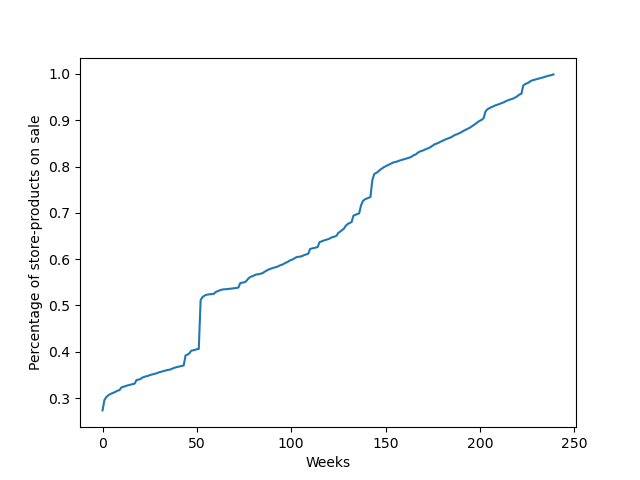

In [ ]:
%matplotlib ipympl
# percentage of product-stores that were sold on or before a specific week
plot_sold_on_or_before(favorita_weekly_sales_flattened)

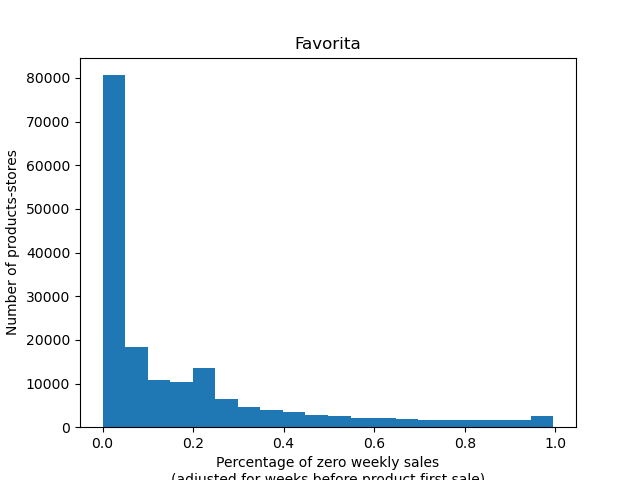

In [ ]:
%matplotlib ipympl
# percentage of weeks in which there were zero sales
plot_percentage_of_zero_weekly_sales(favorita_weekly_sales_flattened, first_week=0, adjusted=True, title='Favorita')

In [ ]:
first_week = 0
favorita_weekly_non_zero_percentage = calculate_percentage_of_zero_weekly_sales(favorita_weekly_sales_flattened, first_week=first_week, adjusted=False)
favorita_weekly_non_zero_percentage_adjusted = calculate_percentage_of_zero_weekly_sales(favorita_weekly_sales_flattened, first_week=first_week, adjusted=True)
favorita_weekly_sold_on_or_before = calculate_sold_on_or_before(favorita_weekly_sales_flattened)

In [ ]:
zero_sales_percentage_thresh = 0.05
sold_by_week = 0

favorita_weekly_sales_filtered, favorita_daily_sales_filtered = filter_weekly_sales(favorita_weekly_sales_flattened, 
                                                                                    favorita_daily_sales_flattened,
                                                                                    favorita_weekly_non_zero_percentage_adjusted, 
                                                                                    #  favorita_weekly_non_zero_percentage, 
                                                                                    favorita_weekly_sold_on_or_before, 
                                                                                    zero_sales_percentage_thresh, 
                                                                                    sold_by_week)
print(favorita_weekly_sales_flattened.shape)
print(favorita_weekly_sales_filtered.shape)
print(favorita_daily_sales_filtered.shape)

torch.Size([174685, 1, 240])
torch.Size([31073, 1, 240])
torch.Size([31073, 1, 1684])


In [ ]:
%matplotlib ipympl
# plot the weekly sales of an item in a store
item = 12333
store = 0
# plot_many_axis(favorita_daily_sales_filtered, item, store)
plot_many_axis(favorita_weekly_sales_filtered, item, store, christmas_weeks=christmas_weeks)

NameError: name 'favorita_weekly_sales_filtered' is not defined

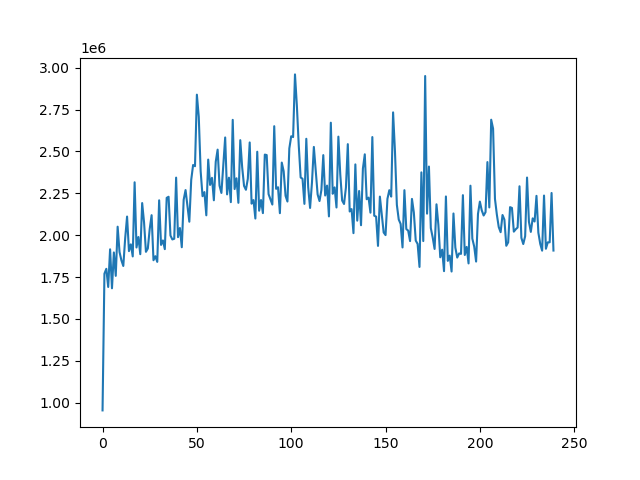

In [ ]:
# aggregated demand and price
%matplotlib ipympl
plt.plot(favorita_weekly_sales_filtered.sum(dim=[0, 1]))
# plt.plot(filtered_prices.mean(dim=[0, 1]))
plt.show()

# Walmart dataset

## Read, pre-process and dump

In [ ]:
# read the data from the m5-forecasting-accuracy dataset
walmart_sales_df = pd.read_csv('Input/m5-forecasting-accuracy/sales_train_evaluation.csv')
walmart_prices_df = pd.read_csv('Input/m5-forecasting-accuracy/sell_prices.csv')

# sort the dataframes by store_id and item_id
walmart_sales_df = walmart_sales_df.sort_values(by=['store_id', 'item_id'])
walmart_prices_df = walmart_prices_df.sort_values(by=['store_id', 'item_id', 'wm_yr_wk'])

# for prices, create a pivot table where each row corresponds to the time series of a single item in a single store
walmart_prices_df = walmart_prices_df.pivot_table(index=['store_id', 'item_id'], columns='wm_yr_wk', values='sell_price').reset_index().fillna(0)

# get a tensor of dimensions (items, stores, time) where each element is the weekly sales of an item in a store
walmart_weekly_sales, walmart_daily_sales = get_weekly_and_daily_sales_tensors(walmart_sales_df, 'store_id', drop_columns=['id', 'item_id', 'dept_id', 'cat_id', 'state_id'])
walmart_weekly_prices = get_tensor_from_df(walmart_prices_df, 'store_id', drop_columns=['item_id'])
n_products, n_stores, n_weeks = walmart_weekly_sales.shape
n_days = walmart_daily_sales.shape[2]

KeyboardInterrupt: 

In [ ]:
# save the tensors to a file
save_tensor(walmart_weekly_sales, 'Input/walmart-tensors/walmart_weekly_sales.pt')
save_tensor(walmart_daily_sales, 'Input/walmart-tensors/walmart_daily_sales.pt')
save_tensor(walmart_weekly_prices[:, :, :n_weeks], 'Input/walmart-tensors/walmart_weekly_prices.pt')

Saved tensor of shape torch.Size([3049, 10, 277]) to Input/walmart-tensors/walmart_weekly_sales.pt
Saved tensor of shape torch.Size([3049, 10, 1941]) to Input/walmart-tensors/walmart_daily_sales.pt
Saved tensor of shape torch.Size([3049, 10, 277]) to Input/walmart-tensors/walmart_weekly_prices.pt


In [ ]:
flattened_sales = walmart_weekly_sales.reshape([n_stores*n_products, 1, n_weeks])
flattened_daily_sales = walmart_daily_sales.reshape([n_stores*n_products, 1, n_days])
flattened_prices = walmart_weekly_prices[:, :, :n_weeks].reshape([n_stores*n_products, 1, n_weeks])

save_tensor(flattened_sales, 'Input/walmart-tensors/walmart_weekly_sales_flattened.pt')
save_tensor(flattened_daily_sales, 'Input/walmart-tensors/walmart_daily_sales_flattened.pt')
save_tensor(flattened_prices, 'Input/walmart-tensors/walmart_weekly_prices_flattened.pt')


Saved tensor of shape torch.Size([30490, 1, 277]) to Input/walmart-tensors/walmart_weekly_sales_flattened.pt
Saved tensor of shape torch.Size([30490, 1, 1941]) to Input/walmart-tensors/walmart_daily_sales_flattened.pt
Saved tensor of shape torch.Size([30490, 1, 277]) to Input/walmart-tensors/walmart_weekly_prices_flattened.pt


## Load tensors and analyze

In [ ]:
walmart_weekly_sales_flattened = torch.load('Input/walmart-tensors/walmart_weekly_sales_flattened.pt')
walmart_daily_sales_flattened = torch.load('Input/walmart-tensors/walmart_daily_sales_flattened.pt')
walmart_weekly_prices_flattened = torch.load('Input/walmart-tensors/walmart_weekly_prices_flattened.pt')

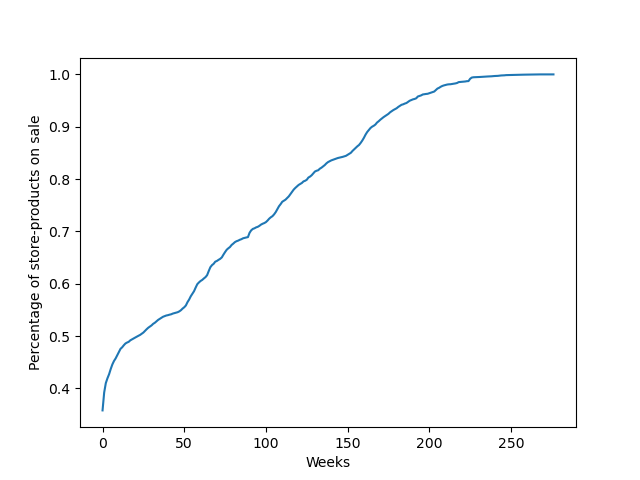

In [ ]:
# percentage of product-stores that were sold on or before a specific week
plot_sold_on_or_before(walmart_weekly_sales_flattened)

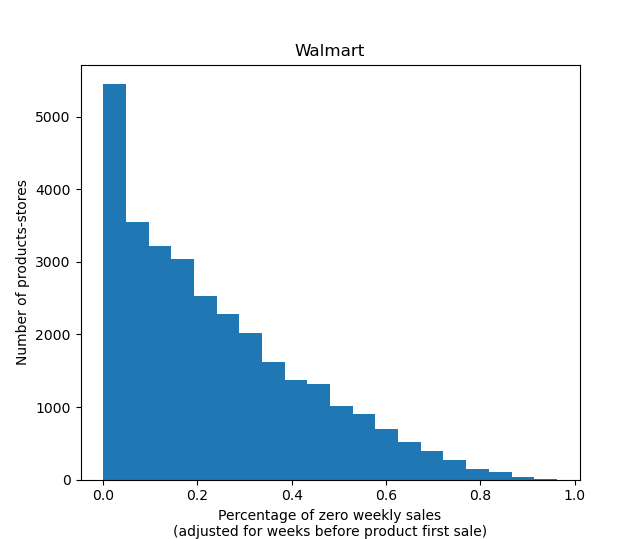

In [ ]:
# percentage of weeks in which there were zero sales
plot_percentage_of_zero_weekly_sales(walmart_weekly_sales_flattened, first_week=0, adjusted=True, title='Walmart')

In [ ]:
first_week = 0
walmart_weekly_non_zero_percentage = calculate_percentage_of_zero_weekly_sales(walmart_weekly_sales_flattened, first_week=first_week, adjusted=False)
walmart_weekly_non_zero_percentage_adjusted = calculate_percentage_of_zero_weekly_sales(walmart_weekly_sales_flattened, first_week=first_week, adjusted=True)
walmart_weekly_sold_on_or_before = calculate_sold_on_or_before(walmart_weekly_sales_flattened)

In [ ]:
zero_sales_percentage_thresh = 0.9
sold_by_week = 0

walmart_weekly_sales_filtered, walmart_daily_sales_filtered = filter_weekly_sales(walmart_weekly_sales_flattened, walmart_daily_sales_flattened,
                                                     walmart_weekly_non_zero_percentage_adjusted, 
                                                    #  favorita_weekly_non_zero_percentage, 
                                                     walmart_weekly_sold_on_or_before, 
                                                     zero_sales_percentage_thresh, 
                                                     sold_by_week)
print(walmart_weekly_sales_flattened.shape)
print(walmart_weekly_sales_filtered.shape)

torch.Size([30490, 1, 277])
torch.Size([10913, 1, 277])


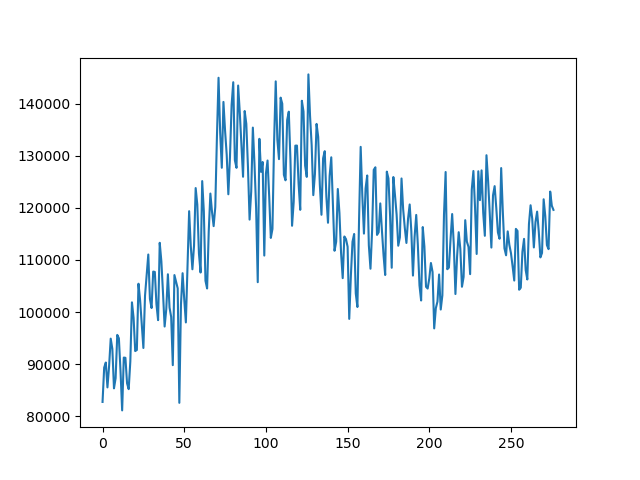

In [ ]:
# aggregated demand and price
%matplotlib ipympl
plt.plot(walmart_weekly_sales_filtered.sum(dim=[0, 1]))
plt.show()

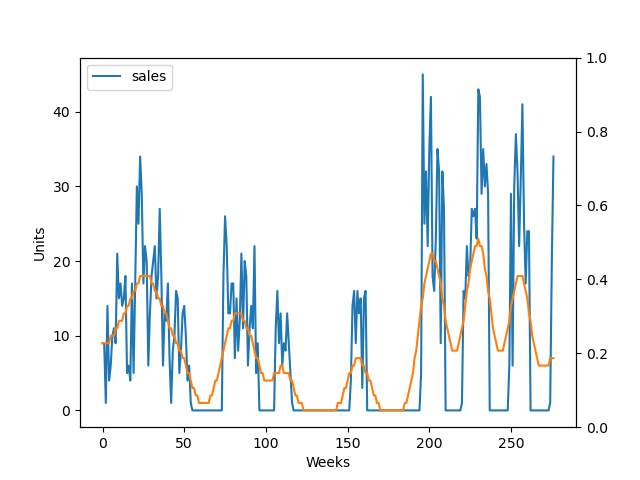

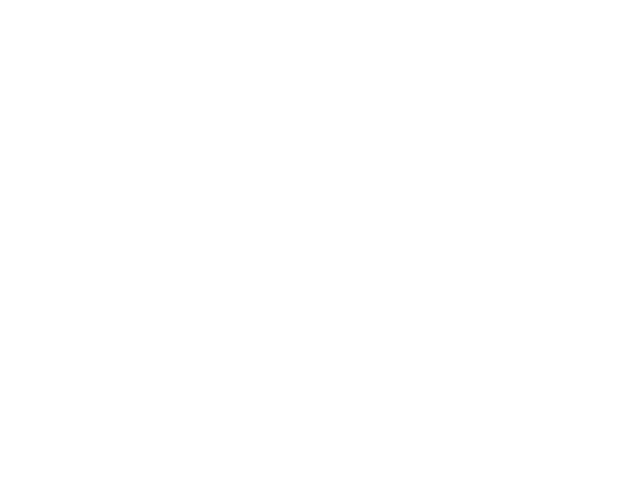

In [ ]:
%matplotlib ipympl
# plot the weekly sales of an item in a store
item = 1304
store = 0
# plot_many_axis(walmart_daily_sales_filtered, item, store)
plot_many_axis(walmart_weekly_sales_filtered, item, store)

In [ ]:
start, end = 100, 101
no_zeroes = weekly_prices[:, :, start: end].sum(dim=[1, 2]) > 0.5
filtered_sales = weekly_sales[no_zeroes]
filtered_prices = weekly_prices[no_zeroes]
print(filtered_sales.shape)

torch.Size([2308, 10, 277])


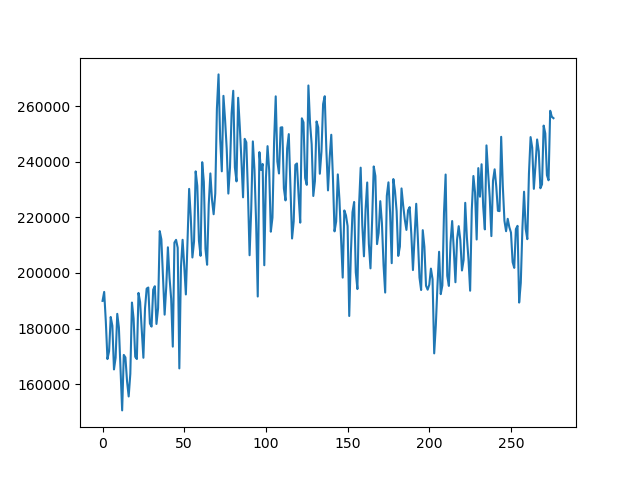

In [ ]:
# aggregated demand and price
%matplotlib ipympl
plt.plot(filtered_sales.sum(dim=[0, 1]))
# plt.plot(filtered_prices.mean(dim=[0, 1]))
plt.show()

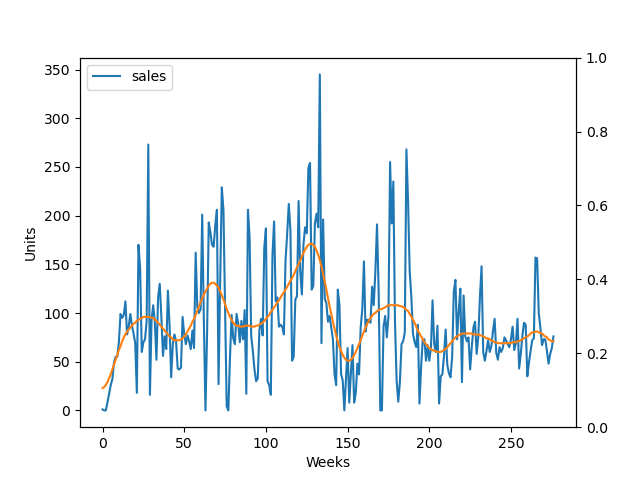

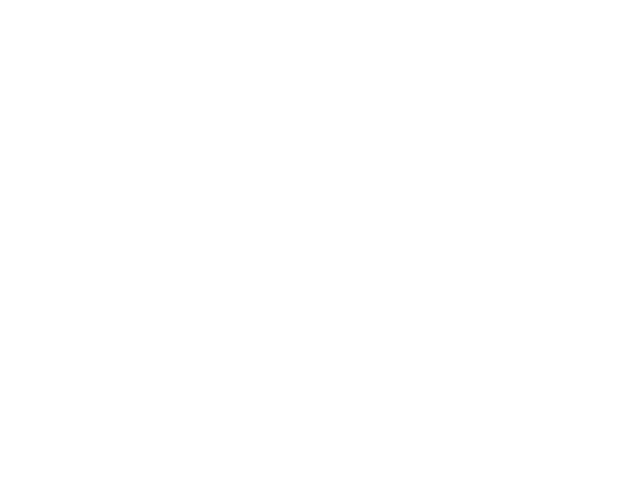

In [ ]:
# sales and prices by unit
%matplotlib ipympl
item = 758
store = 5
plot_weeks = True

plot_many_axis(filtered_sales, item, store, prices=None, time_scale='Weeks')


0.08399783756741827
1964


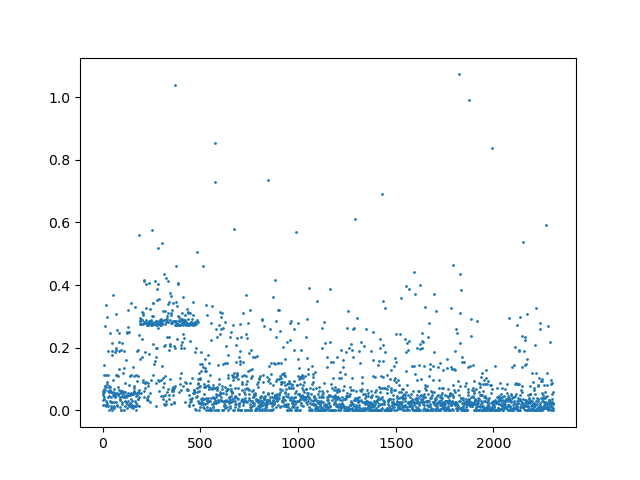

In [ ]:
# Price coefficient of variation
%matplotlib ipympl
filtered_last_periods = filtered_prices[:, :, start:]
coef_of_var = filtered_last_periods.std(dim=[1, 2])/filtered_last_periods.mean(dim=[1, 2])
plt.scatter(np.arange(len(filtered_last_periods)), coef_of_var, s=1)
mean_coef = coef_of_var.mean().item()
print(mean_coef)
small_var = filtered_prices[coef_of_var < 0.2]
print(len(small_var))
plt.show()

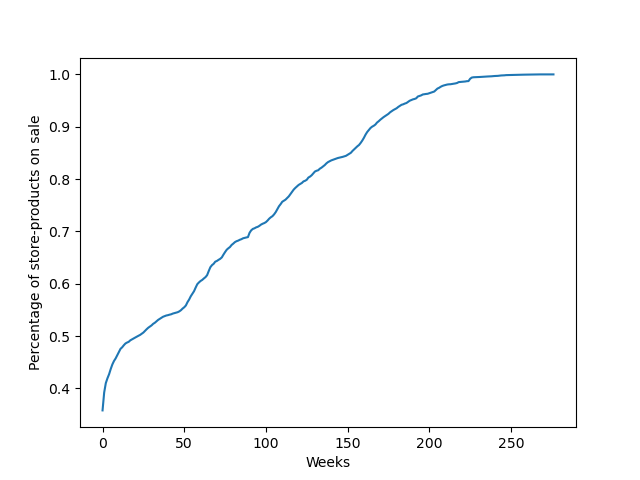

In [ ]:
# number of distinct products that already started to be sold by a specific week
sold_on_week = ((weekly_prices[:, :, :weekly_sales.shape[2]] > 0.01) & (weekly_sales > 0.1)).long()
sold_on_or_before = (sold_on_week.cumsum(dim=2) > 0.5).long()
products_store_sold_by_period = sold_on_or_before.sum(dim=[0, 1])/(n_products*n_stores)

plt.clf()
plt.plot(products_store_sold_by_period)
plt.xlabel('Weeks')
plt.ylabel('Percentage of store-products on sale')
plt.show()

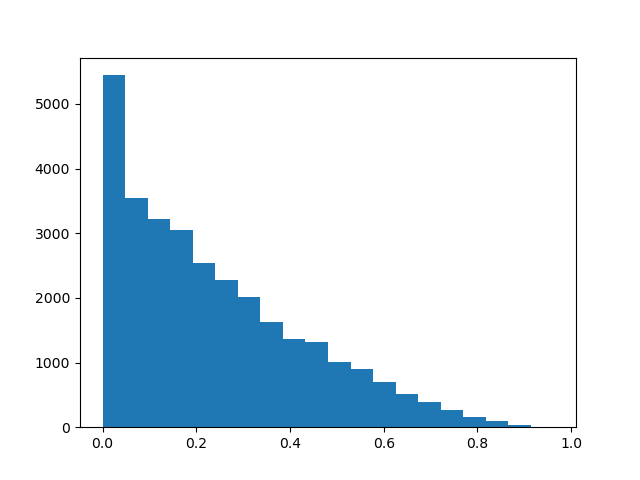

In [ ]:
# percentage of weeks in which there were zero sales
zero_weekly_sales = (weekly_sales == 0).long().sum(dim=2)
number_of_days_from_first_sale = sold_on_or_before.sum(dim=2)
percentage_zero_weekly_sales = zero_weekly_sales/(n_weeks)
adjusted_percentage_zero_weekly_sales = (zero_weekly_sales - (n_weeks - number_of_days_from_first_sale))/number_of_days_from_first_sale

plt.clf()
plt.hist(adjusted_percentage_zero_weekly_sales.flatten().tolist(), bins=20)
# plt.scatter(range(n_products*n_stores), zero_weekly_sales.flatten(), s=1)
plt.show()

torch.Size([30490, 157])
torch.Size([18185, 157])
torch.Size([18185])
torch.Size([12405])


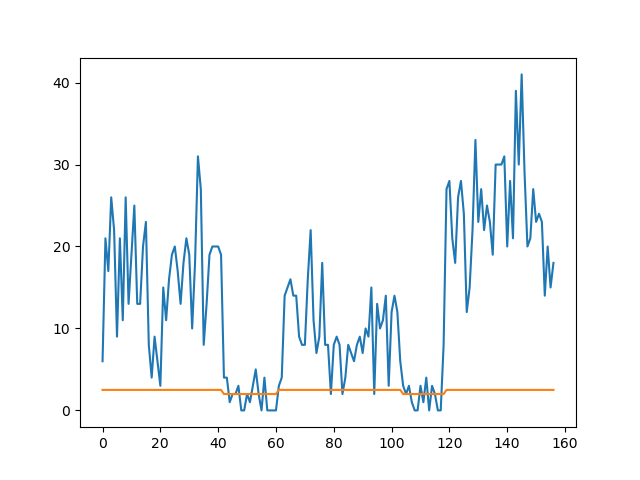

In [ ]:
# percentage of weeks in which there were zero sales
start = 120
flattened_sales = weekly_sales.reshape([n_stores*n_products, n_weeks])[:, start:]
flattened_prices = weekly_prices[:, :, :n_weeks].reshape([n_stores*n_products, n_weeks])[:, start:]
filtered_flattened_sales = flattened_sales[(flattened_prices[:, 0] > 0.1) & (flattened_sales[:, 0] >=1)]
filtered_flattened_prices = flattened_prices[(flattened_prices[:, 0] > 0.1) & (flattened_sales[:, 0] >=1)]

# percentage of weeks with zero sales
flatenned_perc_weekly_sales = ((filtered_flattened_sales == 0).long().sum(dim=1))/(n_weeks - start)

print(flattened_sales.shape)
print(filtered_flattened_sales.shape)
print(flatenned_perc_weekly_sales.shape)
print(flatenned_perc_weekly_sales[flatenned_perc_weekly_sales < 0.25].shape)

thresh = 0.25
not_many_zeros = filtered_flattened_sales[flatenned_perc_weekly_sales < thresh]
not_many_zeros_prices = filtered_flattened_prices[flatenned_perc_weekly_sales < thresh]
many_zeros = filtered_flattened_sales[flatenned_perc_weekly_sales > thresh]

# no_zeroes = weekly_prices[:, :, start: end].sum(dim=[1, 2]) > 0.5
# filtered_sales = weekly_sales[no_zeroes]
# filtered_prices = weekly_prices[no_zeroes]

# zero_weekly_sales = (weekly_sales == 0).long().sum(dim=2)
# number_of_days_from_first_sale = sold_on_or_before.sum(dim=2)

# percentage_zero_weekly_sales = zero_weekly_sales/(n_weeks)
# adjusted_percentage_zero_weekly_sales = (zero_weekly_sales - (n_weeks - number_of_days_from_first_sale))/number_of_days_from_first_sale

plt.clf()
plt.plot(not_many_zeros[1049])
plt.plot(not_many_zeros_prices[1049])
# plt.hist(flatenned_perc_weekly_sales.tolist(), bins=20)
plt.show()